In [107]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [108]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [148]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, column, Date, desc

In [110]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [111]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [112]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [113]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [114]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [115]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bac83d85f0>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [116]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bac83d8470>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [117]:
# Get a list of column names and types for measurement 
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [118]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first() 

('2017-08-23',)

In [119]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set. ChatGPT helped with this.
one_year_ago = datetime.strptime('2017-08-23', '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipdata=session.query(measurement.date, measurement.prcp) \
                            .filter(measurement.date >= one_year_ago) \
                            .filter(measurement.date <= '2017-08-23') \
                            .order_by(measurement.date) \
                            .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipdf = pd.DataFrame(precipdata, columns=['Date', 'Precipitation'])

# Sort the dataframe by date and made sure Date is a date
precipdf['Date']=pd.to_datetime(precipdf['Date'])
precipdf = precipdf.sort_values(by='Date')

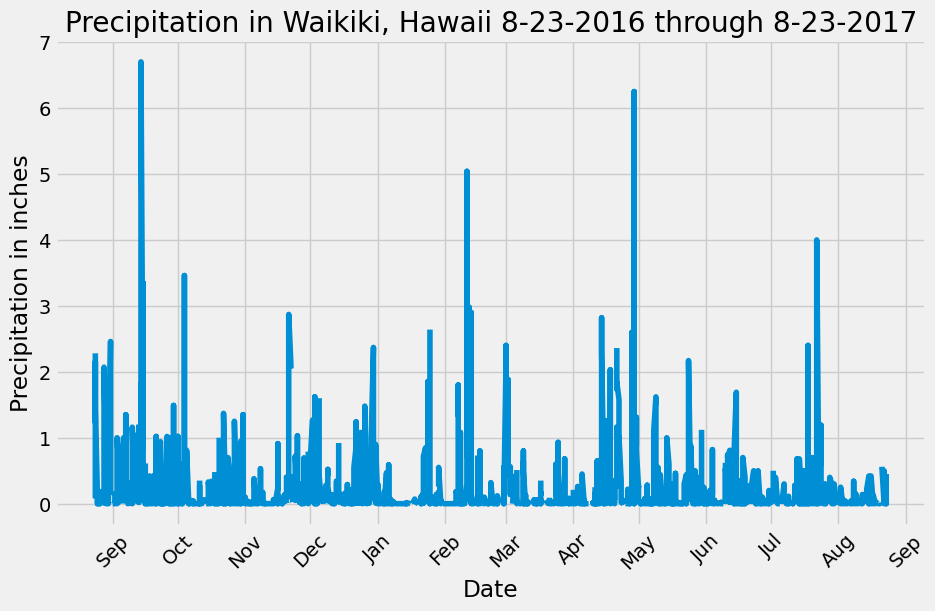

In [120]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
precipdf.set_index('Date', inplace=True)
plt.plot(precipdf.index, precipdf['Precipitation'])

plt.xlabel('Date')
plt.ylabel('Precipitation in inches')
plt.title('Precipitation in Waikiki, Hawaii 8-23-2016 through 8-23-2017')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
date_list = precipdf.index.to_list()

plt.xticks(rotation=45)
plt.tight_layout
plt.show()

In [121]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipdfstats = precipdf.describe()
precipdfstats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [122]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [123]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.station).count()



9

In [124]:
totalrows = session.query(func.count(station.id)).scalar()
totalrows

9

In [141]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stationcounts = session.query(measurement.station, func.count(measurement.id).label('measurement_count')) \
                       .group_by(measurement.station) \
                       .order_by(func.count(measurement.id).desc()) \
                       .all()

# Print stations and their measurement counts
for station_name, measurement_count in stationcounts:
    print(f"Station: {station_name}, Measurement Count: {measurement_count}")

Station: USC00519281, Measurement Count: 2772
Station: USC00519397, Measurement Count: 2724
Station: USC00513117, Measurement Count: 2709
Station: USC00519523, Measurement Count: 2669
Station: USC00516128, Measurement Count: 2612
Station: USC00514830, Measurement Count: 2202
Station: USC00511918, Measurement Count: 1979
Station: USC00517948, Measurement Count: 1372
Station: USC00518838, Measurement Count: 511


In [145]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# USC00519281
stationstats = session.query(func.min(measurement.tobs).label('min_temp'),
                               func.max(measurement.tobs).label('max_temp'),
                               func.avg(measurement.tobs).label('avg_temp')) \
                        .filter(measurement.station == 'USC00519281') \
                        .first()

print(f"Station: USC00519281")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [150]:
# Using the most active station id, USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the data set.
mostrecent = session.query(measurement.date) \
                         .filter(measurement.station == 'USC00519281') \
                         .order_by(desc(measurement.date)) \
                         .first()[0]
mostrecent

'2017-08-18'

In [151]:
# Calculate the date one year from the last date in data set. ChatGPT helped with this.
one_year_ago = datetime.strptime('2017-08-18', '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data
tobsdata=session.query(measurement.date, measurement.tobs) \
                            .filter(measurement.date >= one_year_ago) \
                            .filter(measurement.date <= '2017-08-18') \
                            .order_by(measurement.date) \
                            .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobsdatadf = pd.DataFrame(tobsdata, columns=['Date', 'Temperature'])

# Sort the dataframe by date and made sure Date is a date
tobsdatadf['Date']=pd.to_datetime(tobsdatadf['Date'])
tobsdatadf = tobsdatadf.sort_values(by='Date')



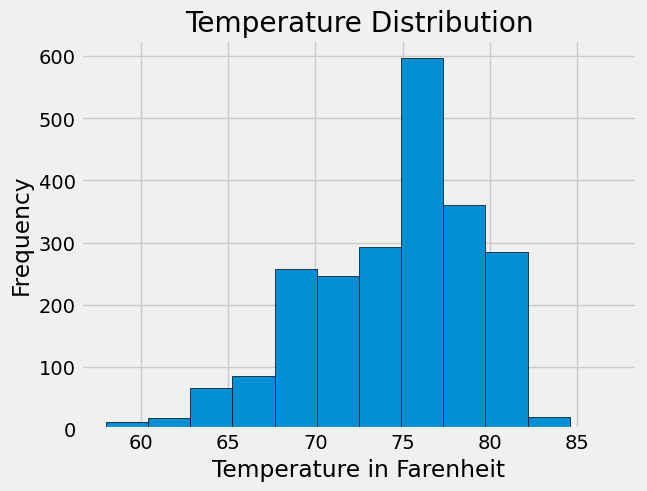

In [152]:
#Histogram
plt.hist(tobsdatadf['Temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature in Farenheit')
plt.ylabel('Frequency')
plt.title('Temperature Distribution 8-18-2016 to 8-18-2017 in Waikiki, Hawaii')
plt.grid(True)
plt.show()

# Close Session

In [153]:
# Close Session
session.close()